In [3]:
# --- Setup ---
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

In [5]:
# File paths (edit these)
PATH_POST = "Creekside Valley Farms _ GCP One _ Pre and Post Soil Data _ 10-2-24.xlsx - Worksheet.csv"
PATH_INTERIM = "GCP One Midterm Sampling _ MW Labs results _ 7-17-25(GCP One Midterm Sampling _ MW L).csv"

# --- Load ---
post = pd.read_csv(PATH_POST)
interim = pd.read_csv(PATH_INTERIM)

# Quick sanity check
#print("POST columns:", list(post.columns))
#print("INTERIM columns:", list(interim.columns))

In [6]:
# ------------------------------------------------------------------------------------
# 1) Organize column AA/AB by field plot (F)
#    In these exports:
#       - Field plot = column F => 'Info3'
#       - Column AA = 'PH'
#       - Column AB = 'BPH'
# ------------------------------------------------------------------------------------
ph_by_plot = (
    post[["Info3", "PH", "BPH"]]
    .rename(columns={"Info3": "Field Plot", "PH": "Baseline_pH", "BPH": "Interim_pH"})
)

In [7]:
# ------------------------------------------------------------------------------------
# 1) Organize column AA/AB by field plot (F)
#    In these exports:
#       - Field plot = column F => 'Info3'
#       - Column AA = 'PH'
#       - Column AB = 'BPH'
# ------------------------------------------------------------------------------------
ph_by_plot = (
    post[["Info3", "PH", "BPH"]]
    .rename(columns={"Info3": "Field Plot", "PH": "Baseline_pH", "BPH": "Interim_pH"})
)

In [8]:
# Summary by plot
ph_plot_summary = (
    ph_by_plot
    .groupby("Field Plot", dropna=False)
    .agg(Baseline_pH_Mean=("Baseline_pH", "mean"),
         Interim_pH_Mean=("Interim_pH", "mean"),
         N_Samples=("Baseline_pH", "count"))
    .reset_index()
)
ph_plot_summary["ΔpH (Interim - Baseline)"] = (
    ph_plot_summary["Interim_pH_Mean"] - ph_plot_summary["Baseline_pH_Mean"]
)

print("\n== Column AA/AB organized by field plot ==")
display(ph_plot_summary)



== Column AA/AB organized by field plot ==


,Field Plot,Baseline_pH_Mean,Interim_pH_Mean,N_Samples,ΔpH (Interim - Baseline)
0,BOYER E,5.033333,5.666667,12,0.633333
1,BOYER W,5.100000,5.825000,12,0.725000
2,CALEB PAYNE,5.400000,6.275000,12,0.875000
3,CARL DERICK W CONTROL,5.366667,6.066667,6,0.700000
4,CARL DERRICK E,5.341667,6.200000,12,0.858333
5,CARL DERRICK M TREATMENT,5.641667,6.425000,12,0.783333
6,CARL DERRICK W CONTROL,5.500000,6.600000,6,1.100000
7,ROBERTS,5.183333,6.016667,12,0.833333
8,NaN,NaN,NaN,0,NaN


In [9]:
# ------------------------------------------------------------------------------------
# 2) Filter POST to post-application date (2024-10-02) and compare to INTERIM pH
#    Match on field plot ('Info3'), compare PH (col Y in the interim sheet is also 'PH').
# ------------------------------------------------------------------------------------
# Guard: ensure date is string; some CSVs parse as datetime
post["Report Date"] = post["Report Date"].astype(str)
post_postapp = post[post["Report Date"] == "2024-10-02"].copy()

post_comp = post_postapp[["Info3", "PH"]].rename(columns={"Info3": "Field Plot", "PH": "PostApp_pH"})
interim_comp = interim[["Info3", "PH"]].rename(columns={"Info3": "Field Plot", "PH": "Interim_pH"})

merged = pd.merge(post_comp, interim_comp, on="Field Plot", how="inner")
print(f"\nMerged rows (matching plots): {len(merged)}")
display(merged.head())

# Field-wise means and change
plot_compare = (
    merged
    .groupby("Field Plot", dropna=False)
    .agg(PostApp_pH_Mean=("PostApp_pH", "mean"),
         Interim_pH_Mean=("Interim_pH", "mean"),
         N_Samples=("PostApp_pH", "count"))
    .reset_index()
)
plot_compare["ΔpH (Interim - PostApp)"] = (
    plot_compare["Interim_pH_Mean"] - plot_compare["PostApp_pH_Mean"]
)

print("\n== Field-wise comparison (Post 2024-10-02 vs Interim) ==")
display(plot_compare.sort_values("ΔpH (Interim - PostApp)", ascending=False))



Merged rows (matching plots): 120


,Field Plot,PostApp_pH,Interim_pH
0,CARL DERRICK W CONTROL,5.5,5.5
1,CARL DERRICK W CONTROL,5.5,5.7
2,CARL DERRICK W CONTROL,5.5,5.7
3,CARL DERRICK W CONTROL,5.5,5.7
4,CARL DERRICK W CONTROL,5.5,5.8



== Field-wise comparison (Post 2024-10-02 vs Interim) ==


,Field Plot,PostApp_pH_Mean,Interim_pH_Mean,N_Samples,ΔpH (Interim - PostApp)
3,ROBERTS,5.216667,5.64,30,0.423333
1,CARL DERRICK M TREATMENT,5.750000,6.12,30,0.370000
2,CARL DERRICK W CONTROL,5.500000,5.68,30,0.180000
0,CALEB PAYNE,5.516667,5.66,30,0.143333



Project-level paired t-test (Interim > PostApp): t=10.133, p=8.912e-18

== Per-plot paired t-tests ==


,Field Plot,n_pairs,t,p
1,CARL DERRICK M TREATMENT,30,8.362845,3.226587e-09
2,CARL DERRICK W CONTROL,30,7.600151,2.226003e-08
3,ROBERTS,30,6.444871,4.736496e-07
0,CALEB PAYNE,30,2.373155,2.448108e-02


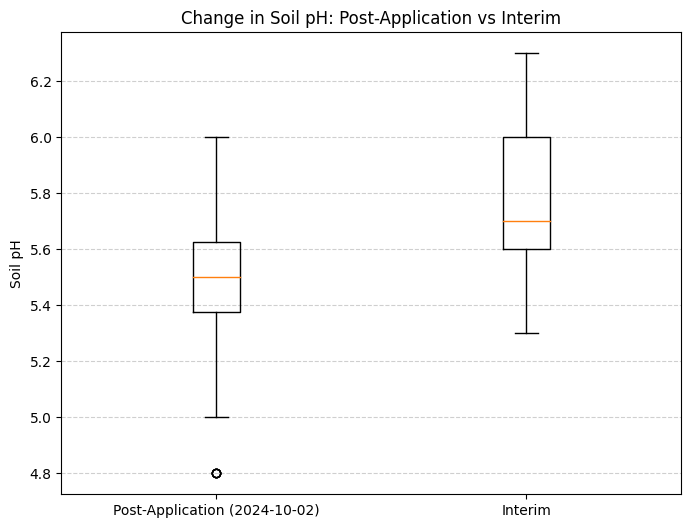

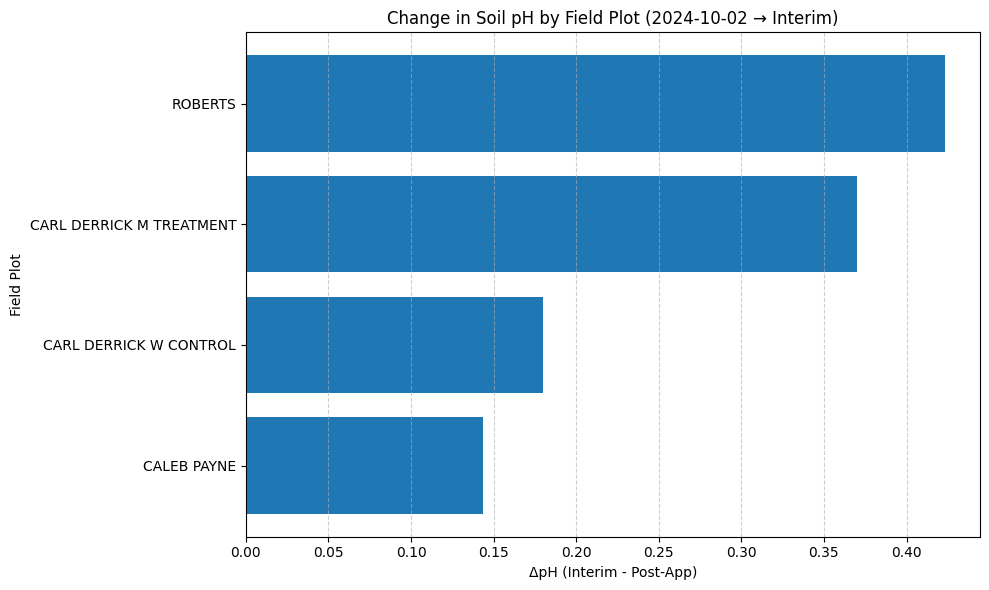

In [10]:
# ------------------------------------------------------------------------------------
# 3) Project-level paired t-test (per-sample matched across plots)
# ------------------------------------------------------------------------------------
paired = merged.dropna(subset=["PostApp_pH", "Interim_pH"])
t_stat, p_val = ttest_rel(paired["Interim_pH"], paired["PostApp_pH"])
print(f"\nProject-level paired t-test (Interim > PostApp): t={t_stat:.3f}, p={p_val:.3e}")

# Optional: per-plot paired tests (useful if multiple paired samples per plot)
def paired_test_by_plot(df):
    rows = []
    for plot, sub in df.groupby("Field Plot"):
        sub = sub.dropna(subset=["PostApp_pH", "Interim_pH"])
        if len(sub) >= 2:  # need at least 2 pairs for t-test to be meaningful
            t, p = ttest_rel(sub["Interim_pH"], sub["PostApp_pH"])
        elif len(sub) == 1:
            t, p = np.nan, np.nan
        else:
            t, p = np.nan, np.nan
        rows.append({"Field Plot": plot, "n_pairs": len(sub), "t": t, "p": p})
    return pd.DataFrame(rows)

per_plot_tests = paired_test_by_plot(merged)
print("\n== Per-plot paired t-tests ==")
display(per_plot_tests.sort_values("p"))

# ------------------------------------------------------------------------------------
# 4) Visualizations
#    (Note: don't set custom colors/styles to keep this portable)
# ------------------------------------------------------------------------------------
# Boxplot: project-level shift in pH
plt.figure(figsize=(8,6))
plt.boxplot([paired["PostApp_pH"], paired["Interim_pH"]],
            labels=["Post-Application (2024-10-02)", "Interim"])
plt.title("Change in Soil pH: Post-Application vs Interim")
plt.ylabel("Soil pH")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()

# Bar chart: ΔpH by field plot
plt.figure(figsize=(10,6))
ordered = plot_compare.sort_values("ΔpH (Interim - PostApp)", ascending=True)
plt.barh(ordered["Field Plot"], ordered["ΔpH (Interim - PostApp)"])
plt.xlabel("ΔpH (Interim - Post-App)")
plt.ylabel("Field Plot")
plt.title("Change in Soil pH by Field Plot (2024-10-02 → Interim)")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



In [12]:
# ------------------------------------------------------------------------------------
# 5) (Optional) Save outputs
# ------------------------------------------------------------------------------------
ph_plot_summary.to_csv("organized_AA_AB_by_field_plot.csv", index=False)
plot_compare.to_csv("post_vs_interim_field_summary.csv", index=False)
per_plot_tests.to_csv("per_plot_paired_ttests.csv", index=False)
print("\nSaved: organized_AA_AB_by_field_plot.csv, post_vs_interim_field_summary.csv, per_plot_paired_ttests.csv")



Saved: organized_AA_AB_by_field_plot.csv, post_vs_interim_field_summary.csv, per_plot_paired_ttests.csv
